In [13]:
import pandas as pd
import geopandas as gpd
import folium 
import matplotlib.pyplot as plt
import mapclassify
from census import Census
import requests
import numpy as np
%config InlineBackend.figure_format ='retina'

In [2]:
# importing EPA walkability index by census tract 2021
walkability = pd.read_csv('../urabanfarms/EPA_SmartLocationDatabase_V3_Jan_2021_Final.csv')
walkability = walkability[walkability['STATEFP'] == 48]

walkability['TRACT'] = walkability['TRACTCE'].apply(lambda x: f'{x:06d}')
walkability['COUNTY'] = walkability['COUNTYFP'].apply(lambda x: f'{x:03d}')

walkability['STATEFP'] = walkability['STATEFP'].astype(str)
walkability['COUNTY'] = walkability['COUNTY'].astype(str)
walkability['TRACT'] = walkability['TRACT'].astype(str)

walkability['GEOID'] = walkability['STATEFP'] + walkability['COUNTY'] + walkability['TRACT']
walkability['GEOID'] = walkability['GEOID'].astype(int)

newalk = walkability[['GEOID', 'NatWalkInd']].groupby(by = 'GEOID').mean()

In [3]:
# 2021 CENSUS DATA

c = Census('ae76560b57d910bf5513f6d8889b137554e13cd6')

texas21 = c.acs.state_county_tract(fields = ('B06011_001E','B01003_001E','B02001_002E','B08014_002E','B17001_002E','B10052_002E'),  state_fips='48', county_fips='*', tract="*", year = 2021)
texas21 = pd.DataFrame(texas21)

texas21 = texas21.rename(columns={'B06011_001E' : 'Median Income',
            'B01003_001E' : 'Population',
            'B17001_002E': 'Population Below Poverty Level',
            'B02001_002E': 'Population White Only',
            'B08014_002E': 'Population No Vehicle Access',
            'B10052_002E': 'Disabled Population'})
texas21['geoid'] = texas21['state'] + texas21['county'] + texas21['tract']
texas21['geoid'] = texas21['geoid'].astype(int)

texas21 = texas21.merge(newalk, left_on='geoid', right_on='GEOID', how='left')

In [4]:
#buffering SNAP eligable stores by 1 mile
SNAPstores = pd.read_csv('../urabanfarms/texas_SNAP_stores.csv')
SNAPstores = gpd.GeoDataFrame(SNAPstores, geometry = gpd.points_from_xy(SNAPstores.Longitude, SNAPstores.Latitude))

SNAPgrocery = SNAPstores[(SNAPstores['Store Type'] == 'Large Grocery Store') | (['Store Type'] == 'Medium Grocery Store') | (['Store Type'] == 'Small Grocery Store') | (['Store Type'] =='Supermarket')| (['Store Type'] == 'Super Store')]

SNAPgrocery = SNAPgrocery.set_crs(epsg=4326)
SNAPgrocery = SNAPgrocery.to_crs(epsg=32614)

SNAPgrocery["buffered_grocery"] = SNAPgrocery["geometry"].buffer(1609.34)

In [5]:
#census tract shapefile

censustracts = gpd.read_file('../urabanfarms/tl_2021_48_tract.zip')
censustracts['GEOID'] = censustracts['GEOID'].astype(int)
censustracts = gpd.GeoDataFrame(censustracts)

#finding percent of census tract >1 mile from grocery store 

censustracts = censustracts.to_crs(epsg=4326)
censustracts = censustracts.to_crs(epsg=32614)

censustracts['tract_area'] = censustracts.geometry.area

In [6]:
# percent within 1 mile of a SNAP grocery store
covered_percentages = []
for idx, tract in censustracts.iterrows():
    tract_geometry = tract.geometry
    tract_name = tract.name
    intersecting_buffers = SNAPgrocery[SNAPgrocery['buffered_grocery'].intersects(tract_geometry)]
    if not intersecting_buffers.empty:
        unioned_buffers = intersecting_buffers['buffered_grocery'].unary_union
        covered_area = unioned_buffers.intersection(tract_geometry).area
    else:
        covered_area = 0
    percentage_covered = (covered_area / tract['tract_area']) * 100
    covered_percentages.append(percentage_covered)
censustracts['Percentage_Covered'] = covered_percentages
tract = censustracts.reset_index()[['GEOID', 'tract_area', 'Percentage_Covered', 'geometry']]

<Axes: >

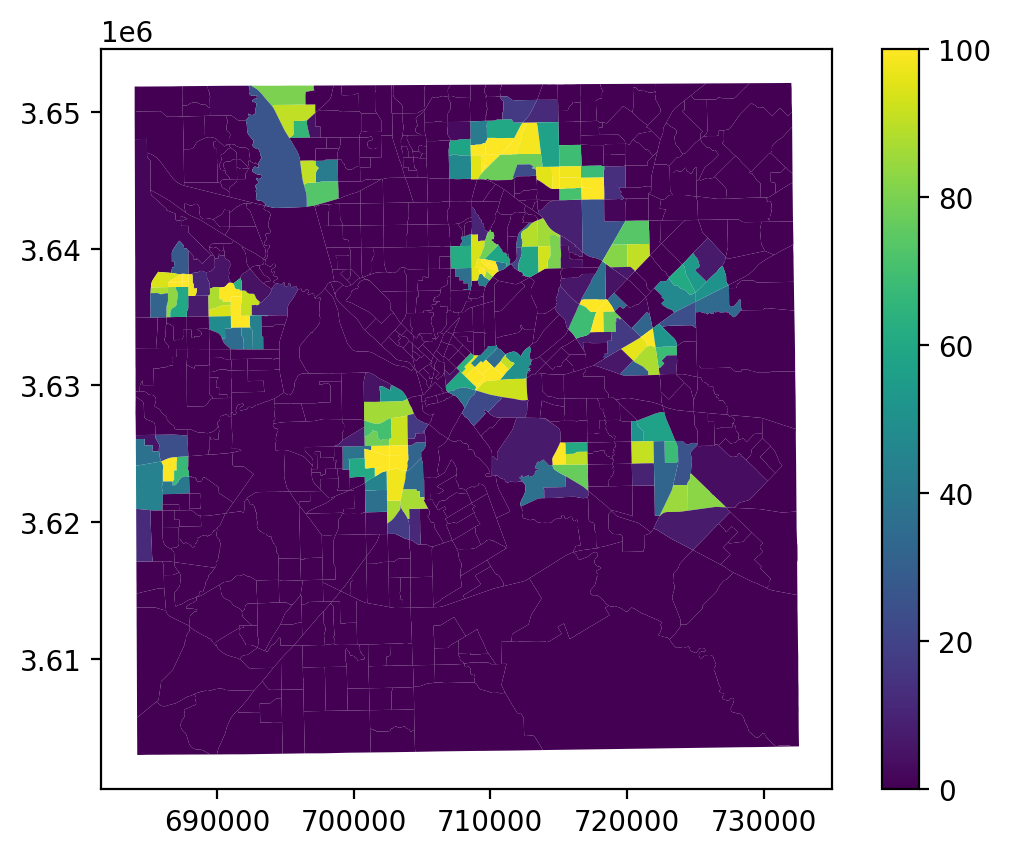

In [7]:
texas21MAP = tract.merge(texas21, left_on='GEOID', right_on='geoid', how='inner')

SNAPmap = texas21MAP[texas21MAP['county'] == '113'].plot('Percentage_Covered', legend = True)
SNAPmap

In [26]:
# making low income, low access variables, and food desert variables

#low access variable
texas21MAP['Low Access'] = (texas21MAP['Percentage_Covered'] < 66) | ((100 - texas21MAP['Percentage_Covered']) / 100 * texas21MAP['Population'] > 500)

#COUNTIES (city, county, FIPS code)
#houston = harris = 201
#san antonio = bexar = 029
#dallas = dallas = 113
#austin = travis = 543
#forth worth = tarrant = 439

#low income variable
DallasMedianIncome21 = 65011
HoustonMedianIncome21 = 65788
SanAntonioMedianIncome21 = 62169
AustinMedianIncome21 = 85043
FortWorthMedianIncome21 = 73545

texas21MAP['Poverty Rate'] = texas21MAP['Population Below Poverty Level'] / texas21MAP['Population']
conditions = [
    (texas21MAP['county'] == '113') & ((texas21MAP['Poverty Rate'] >= 0.2) | (texas21MAP['Median Income'] <= DallasMedianIncome21 * 0.8)),
    (texas21MAP['county'] == '201') & ((texas21MAP['Poverty Rate'] >= 0.2) | (texas21MAP['Median Income'] <= HoustonMedianIncome21 * 0.8)),
    (texas21MAP['county'] == '029') & ((texas21MAP['Poverty Rate'] >= 0.2) | (texas21MAP['Median Income'] <= SanAntonioMedianIncome21 * 0.8)),
    (texas21MAP['county'] == '543') & ((texas21MAP['Poverty Rate'] >= 0.2) | (texas21MAP['Median Income'] <= AustinMedianIncome21 * 0.8)),
    (texas21MAP['county'] == '439') & ((texas21MAP['Poverty Rate'] >= 0.2) | (texas21MAP['Median Income'] <= FortWorthMedianIncome21 * 0.8))
]
choices = [True, True, True, True, True]
texas21MAP['Low Income'] = np.select(conditions, choices, default=np.nan)

texas21MAP['Food Desert'] = (texas21MAP['Low Access'] == True) & (texas21MAP['Low Income'] == 1)

/tmp/ipykernel_3087540/804611532.py:3: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  SNAPgrocery[SNAPgrocery['County'] == 'HOUSTON'].plot(ax=blah, color = 'red')


<Axes: >

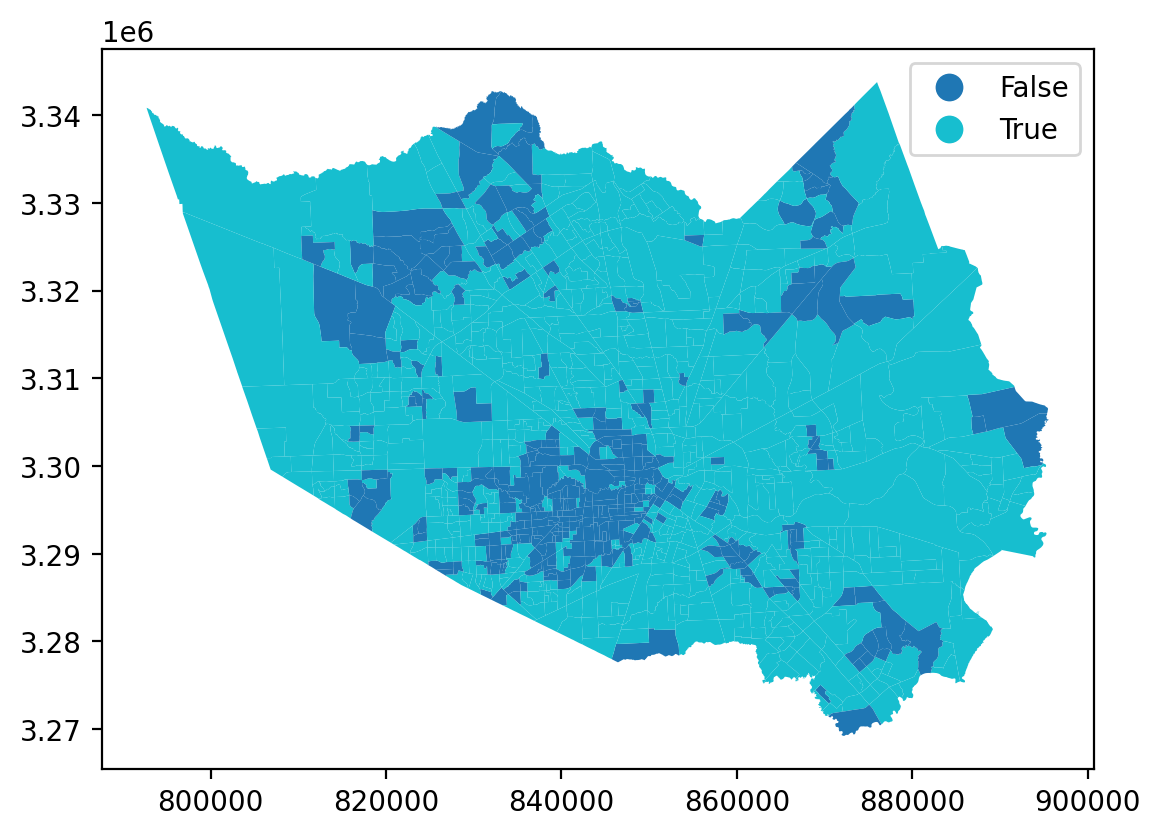

In [30]:
base = texas21MAP[texas21MAP['county'] == '201'].plot('Food Desert', legend = True)
SNAPgrocery[SNAPgrocery['County'] == 'HOUSTON'].plot(ax=base, color = 'red')